Archivos: census_train.csv, census_test.csv
Este conjunto de datos es una versión modificada del utilizado en el artículo [Scaling Up the
Accuracy of Naive-Bayes Classifiers: a Decision-Tree Hybrid](https://www.aaai.org/Papers/KDD/1996/KDD96-033.pdf), escrito por Ron Kohavi. Los datos originales se pueden encontrar en el [UC Irvine Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Census+Income).

El objetivo es predecir si los ingresos de una persona superan o no los 50.000$ (variable
income). Para ello, se tienen 13 características:

* age: Edad
* workclass: tipo de ocupación (Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked)
* education_level: Nivel educativo (Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool)
* education-num: Número de años de educación completados.
* marital-status: estado civil (Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse)
* occupation: ocupación (Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces)
* relationship: familia (Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried)
* race : ​ raza (White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other, Black)
* sex ​ : Género (Female, Male)
* capital-gain : ​ Ganancia de capitales
* capital-loss : ​ Pérdida de capitales
* hours-per-week ​ : Promedio de horas trabajadas por semana
* native-country : ​ País de origen (United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinidad&Tobago, Peru, Hong, Holand-Netherlands)

### Realizamos los imports necesarios y creamos las funciones necesarias

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib inline

from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder, StandardScaler

cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import confusion_matrix

from sklearn.linear_model import LogisticRegression

from sklearn.feature_selection import f_classif, mutual_info_classif

from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import roc_curve, auc

from sklearn.ensemble import RandomForestClassifier

from sklearn.ensemble import GradientBoostingClassifier

from sklearn.svm import SVC


In [2]:
def plot_confusion_matrix(confmat):
    fig, ax = plt.subplots(figsize=(3, 3))
    ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.5)
    for i in range(confmat.shape[0]):
        for j in range(confmat.shape[1]):
            ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')

    plt.xlabel('predicted label')
    plt.ylabel('true label')

    plt.tight_layout()
    plt.show()

In [3]:
def calcula_metricas(confmat):
    
    tn, fp, fn, tp = confmat.ravel()

    acc = (tp+tn)/(tn + fp + fn + tp)
    sen = tp/(tp+fn)
    esp = tn/(tn+fp)
    ppv = tp/(tp+fp)
    fsc = 2*(sen*ppv/(sen+ppv))

    print('ACC: ', acc)
    print('SEN: ', sen)
    print('ESP: ', esp)
    print('PPV: ', ppv)
    print('FSC: ', fsc)
    
    plt.bar(range(5),[acc,sen,esp,ppv,fsc])
    plt.xticks(range(5),['ACC','SEN','ESP','PPV','FSC'])
    plt.plot([-1, 6], [1, 1], color=(0.6, 0.6, 0.6), linestyle='--')
    plt.xlim((-0.5,4.5))
    plt.ylim((0,1.1))
    plt.title('Metricas')
    plt.show()

### Análisis exploratorio

In [4]:
# cargamos el fichero de datos y mostramos las primeras filas para tomar una primera impresión de los datos
data = pd.read_csv('https://github.com/ivanrumo/KC_Practica_Machine_Learning/blob/master/data/census_train.csv?raw=true')#'data/census_train.csv')
data.head(10)

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,49,Private,Masters,14.0,Divorced,Sales,Unmarried,Other,Female,0.0,0.0,20.0,Peru,<=50K
1,43,Private,Assoc-acdm,12.0,Divorced,Craft-repair,Not-in-family,White,Male,0.0,0.0,40.0,United-States,<=50K
2,53,Private,Doctorate,16.0,Married-civ-spouse,Prof-specialty,Wife,White,Female,99999.0,0.0,37.0,United-States,>50K
3,23,Private,HS-grad,9.0,Married-civ-spouse,Adm-clerical,Wife,White,Female,3908.0,0.0,40.0,United-States,<=50K
4,32,Private,Some-college,10.0,Divorced,Handlers-cleaners,Unmarried,Black,Male,0.0,0.0,40.0,Nicaragua,<=50K
5,29,Federal-gov,Some-college,10.0,Married-spouse-absent,Adm-clerical,Own-child,White,Female,0.0,0.0,40.0,United-States,<=50K
6,51,Private,Some-college,10.0,Never-married,Adm-clerical,Own-child,White,Female,0.0,0.0,40.0,United-States,<=50K
7,33,Self-emp-inc,HS-grad,9.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,50.0,United-States,<=50K
8,35,Local-gov,Masters,14.0,Married-civ-spouse,Prof-specialty,Husband,White,Male,0.0,0.0,40.0,United-States,<=50K
9,39,Private,Some-college,10.0,Married-civ-spouse,Sales,Husband,White,Male,0.0,0.0,40.0,United-States,<=50K


Vemos algunas variables que pueden ser categóricas, algunos valores aprimera vista dispares, etc.
education_level y education-num parece que representan la mismo información. 

In [5]:
data.shape

(36177, 14)

vemos que tenemos 13 variables (+ la objetivo) y mas de 36.000 muestras

In [6]:
data['income'].value_counts()

<=50K    27211
>50K      8966
Name: income, dtype: int64

La variable está desbalanceada. **Mas del 75% gana menos de $50K**

In [7]:
data.dtypes

age                  int64
workclass           object
education_level     object
education-num      float64
marital-status      object
occupation          object
relationship        object
race                object
sex                 object
capital-gain       float64
capital-loss       float64
hours-per-week     float64
native-country      object
income              object
dtype: object

confirmamos que tenemos varias variables de texto y tenemos que explorar sus valores para comprobar si con categóricas

In [8]:
data.isnull().any()

age                False
workclass          False
education_level    False
education-num      False
marital-status     False
occupation         False
relationship       False
race               False
sex                False
capital-gain       False
capital-loss       False
hours-per-week     False
native-country     False
income             False
dtype: bool

por suerte no tenemos valores nulos

In [9]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
age,36177.0,38.598751,13.229011,17.0,28.0,37.0,47.0,90.0
education-num,36177.0,10.113663,2.553911,1.0,9.0,10.0,13.0,16.0
capital-gain,36177.0,1088.861735,7506.099972,0.0,0.0,0.0,0.0,99999.0
capital-loss,36177.0,88.133206,404.279205,0.0,0.0,0.0,0.0,4356.0
hours-per-week,36177.0,40.881582,11.981588,1.0,40.0,40.0,45.0,99.0


Las variables capital-gain, capital-loss y hours-per-week tienen valores máximos muy altos. 
Tengo que comprobar mas adelante si tenemos outliers

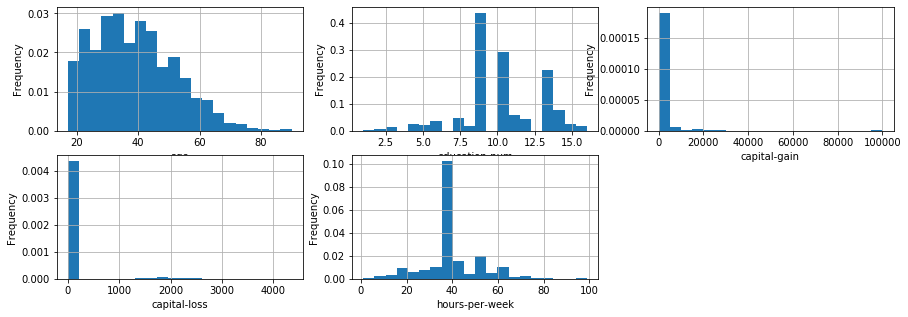

In [10]:
plt.figure(figsize=(15, 5))

plt.subplot(2,3,1)
data['age'].plot.hist(bins=20, density=1, grid = True)
plt.xlabel('age')

plt.subplot(2,3,2)
data['education-num'].plot.hist(bins=20, density=1, grid = True)
plt.xlabel('education-num')

plt.subplot(2,3,3)
data['capital-gain'].plot.hist(bins=20, density=1, grid = True)
plt.xlabel('capital-gain')

plt.subplot(2,3,4)
data['capital-loss'].plot.hist(bins=20, density=1, grid = True)
plt.xlabel('capital-loss')

plt.subplot(2,3,5)
data['hours-per-week'].plot.hist(bins=20, density=1, grid = True)
plt.xlabel('hours-per-week')

plt.show()

**age** Vemos una distribución normal. Tenemos algunos valores muy altos poco representativos. 

**education-num** Los valores entre 9 y 13 son los mas abundantes

**capital-gain** y **capital-loss** en la mayoría de casos su valor es cero. Es posible que estas variables no tengan que estar en el modelo. Más adelante lo podré comprobar.

**hours-per-week** como es lógico alrrededor de las 40 horas semanales es el valor predominante. 

In [11]:
print("% capital-gain valores = 0: {}".format(data[(data['capital-gain'] == 0)].shape[0] / data.shape[0]))
print("% capital-loss valores = 0: {}".format(data[(data['capital-loss'] == 0)].shape[0] / data.shape[0]))
print("% capital-gain y capital-loss ambos valores = 0: {}".format(data[(data['capital-gain'] == 0) & (data['capital-loss'] == 0)].shape[0] / data.shape[0]))

% capital-gain valores = 0: 0.9175719379716394
% capital-loss valores = 0: 0.9529811758852309
% capital-gain y capital-loss ambos valores = 0: 0.8705531138568704


Para capital gain mas del 90% de los valores es 0

En el caso de capital loss es mas del 95%

Ambas variables tienen como valor 0 en el 87% de las muestras.

Seguramente estas variables deban eliminarse. Por ahora las mantengo y en función de los resultados de los modelos barajaré sacar las variables para entrenar los modelos.

---

He probado a eliminar estas variables y he obtenido peores modelos, así que al final mantengo estas variables. Parece que en las muestras que si tienen valor son útiles para el modelo predictorio

In [12]:
#data = data.drop(['capital-gain'],axis=1)
#data = data.drop(['capital-loss'],axis=1)

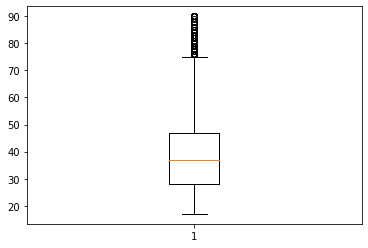

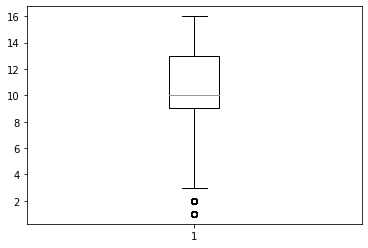

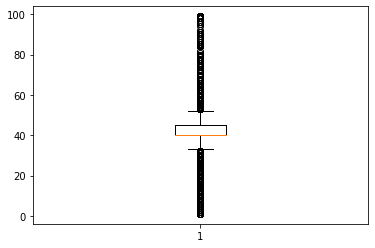

In [13]:
plt.boxplot(data['age'])
plt.show()

plt.boxplot(data['education-num'])
plt.show()

plt.boxplot(data['hours-per-week'])
plt.show()


Vemos que en hours-per-week y age tenemos outliers. Sobre todo en hours-per-week. Seguramente posteriormente haga limpieza de outliers para ajustar mejor los resultados de los modelos

---
He hecho pruebas quitando los outliers y obtengo peores resultados. Así que mantengo todas las muestras

In [14]:
data[['education_level', 'education-num']].head(50)

,education_level,education-num
0,Masters,14.0
1,Assoc-acdm,12.0
2,Doctorate,16.0
3,HS-grad,9.0
4,Some-college,10.0
5,Some-college,10.0
6,Some-college,10.0
7,HS-grad,9.0
8,Masters,14.0
9,Some-college,10.0


Efectivamente vemos que education_level y education-num representan los mismos datos. 

Por lo tanto eliminamos education_level del dataset

In [15]:
data = data.drop(['education_level'],axis=1)
data.head()

,age,workclass,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,49,Private,14.0,Divorced,Sales,Unmarried,Other,Female,0.0,0.0,20.0,Peru,<=50K
1,43,Private,12.0,Divorced,Craft-repair,Not-in-family,White,Male,0.0,0.0,40.0,United-States,<=50K
2,53,Private,16.0,Married-civ-spouse,Prof-specialty,Wife,White,Female,99999.0,0.0,37.0,United-States,>50K
3,23,Private,9.0,Married-civ-spouse,Adm-clerical,Wife,White,Female,3908.0,0.0,40.0,United-States,<=50K
4,32,Private,10.0,Divorced,Handlers-cleaners,Unmarried,Black,Male,0.0,0.0,40.0,Nicaragua,<=50K


### Feature Engineering

La variable objetivo la vamos a codificar. Cuando el valor sea <=50K podremos un 0 y cuando sea >50K sea 1

In [16]:
data['income'] = np.where(data['income'] == '<=50K',0,1)
np.unique(data['income'], return_counts=True) # comprovamos que la conversión se ha hecho bien

(array([0, 1]), array([27211,  8966]))

In [17]:
cols = data.columns[data.dtypes == 'object']
cols

Index(['workclass', 'marital-status', 'occupation', 'relationship', 'race',
       'sex', 'native-country'],
      dtype='object')

Vamos a estudiar los valores de las variables categóricas

In [18]:
for col in cols:
    print(data[col].value_counts())

 Private             26572
 Self-emp-not-inc     3063
 Local-gov            2479
 State-gov            1576
 Self-emp-inc         1313
 Federal-gov          1156
 Without-pay            18
Name: workclass, dtype: int64
 Married-civ-spouse       16872
 Never-married            11683
 Divorced                  5059
 Separated                 1098
 Widowed                   1002
 Married-spouse-absent      442
 Married-AF-spouse           21
Name: marital-status, dtype: int64
 Prof-specialty       4839
 Craft-repair         4828
 Exec-managerial      4748
 Adm-clerical         4461
 Sales                4312
 Other-service        3810
 Machine-op-inspct    2403
 Transport-moving     1840
 Handlers-cleaners    1634
 Farming-fishing      1187
 Tech-support         1137
 Protective-serv       782
 Priv-house-serv       188
 Armed-Forces            8
Name: occupation, dtype: int64
 Husband           14984
 Not-in-family      9357
 Own-child          5299
 Unmarried          3812
 Wife        

**workclass** La mayoría de valores son de trabajadores por cuenta ajena. Creo que se podrían juntar por un lado los funcionarios (*-gov) y por otro lado los autónomos (self-emp*). Los desempleados son una muestra tan pequeña que quizá se pudan eliminar

**native-country** La mayoría de muestras corresponden a Estados Unidos. Seguramente sea aconsejable agrupar todos los valores que no son Estados Unidos en un solo valor. 

**race** Pasa parecido al pais. Casi todas las muestras son de raza blanca. Seguramente es aconsejable agrupar las muestras que no son raza blanca en un solo valor.

In [19]:
#workclass
'''
data.loc[data.workclass.str.contains("gov"), 'workclass'] = 'Government'
data.loc[data.workclass.str.contains("Self"), 'workclass'] = 'Self'
data = data[~data.workclass.str.contains('Without-pay')]
print(data['workclass'].value_counts())

#race
data.loc[~data.race.str.contains("White"), 'race'] = 'non-White'
print(data['race'].value_counts())

#native-country
data.loc[~data['native-country'].str.contains("United-States"), 'native-country'] = 'non-United-States'
print(data['native-country'].value_counts())'''

'\ndata.loc[data.workclass.str.contains("gov"), \'workclass\'] = \'Government\'\ndata.loc[data.workclass.str.contains("Self"), \'workclass\'] = \'Self\'\ndata = data[~data.workclass.str.contains(\'Without-pay\')]\nprint(data[\'workclass\'].value_counts())\n\n#race\ndata.loc[~data.race.str.contains("White"), \'race\'] = \'non-White\'\nprint(data[\'race\'].value_counts())\n\n#native-country\ndata.loc[~data[\'native-country\'].str.contains("United-States"), \'native-country\'] = \'non-United-States\'\nprint(data[\'native-country\'].value_counts())'

Mantengo los datos como vienen en el dataset. Con las tranformaciones obtengo modelos algo peores. Así que mantengo los valores como vienen de origen 

~~Como los datos no pertenecen a una serie temporal, vamos a codificar las variables categóricas de dos valores con LabelEncoder. Las de mas valores vamos a codificarlas con get_dummies~~

Al final codifico todas las variables categóricas con LabelEncoder. Así obtengo mejores resultados.

In [20]:
le = LabelEncoder()

cols_bin = ['race', 'sex', 'native-country', 'workclass', 'marital-status', 'occupation', 'relationship']

for col in cols_bin:
    data[col] = le.fit_transform(data[col])



In [21]:
'''
cols = ['workclass', 'marital-status', 'occupation', 'relationship']

for col in cols:
    dummy = pd.get_dummies(data[col])
    data = pd.concat([data,dummy],axis=1).drop([col],axis=1)


data.head()'''

"\ncols = ['workclass', 'marital-status', 'occupation', 'relationship']\n\nfor col in cols:\n    dummy = pd.get_dummies(data[col])\n    data = pd.concat([data,dummy],axis=1).drop([col],axis=1)\n\n\ndata.head()"

In [22]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
age,36177.0,38.598751,13.229011,17.0,28.0,37.0,47.0,90.0
workclass,36177.0,2.205877,0.963834,0.0,2.0,2.0,2.0,6.0
education-num,36177.0,10.113663,2.553911,1.0,9.0,10.0,13.0,16.0
marital-status,36177.0,2.579678,1.498088,0.0,2.0,2.0,4.0,6.0
occupation,36177.0,5.964701,4.026909,0.0,2.0,6.0,9.0,13.0
relationship,36177.0,1.408519,1.596411,0.0,0.0,1.0,3.0,5.0
race,36177.0,3.681842,0.830472,0.0,4.0,4.0,4.0,4.0
sex,36177.0,0.677088,0.467596,0.0,0.0,1.0,1.0,1.0
capital-gain,36177.0,1088.861735,7506.099972,0.0,0.0,0.0,0.0,99999.0
capital-loss,36177.0,88.133206,404.279205,0.0,0.0,0.0,0.0,4356.0


#### Pintamos histogramas para cada clase

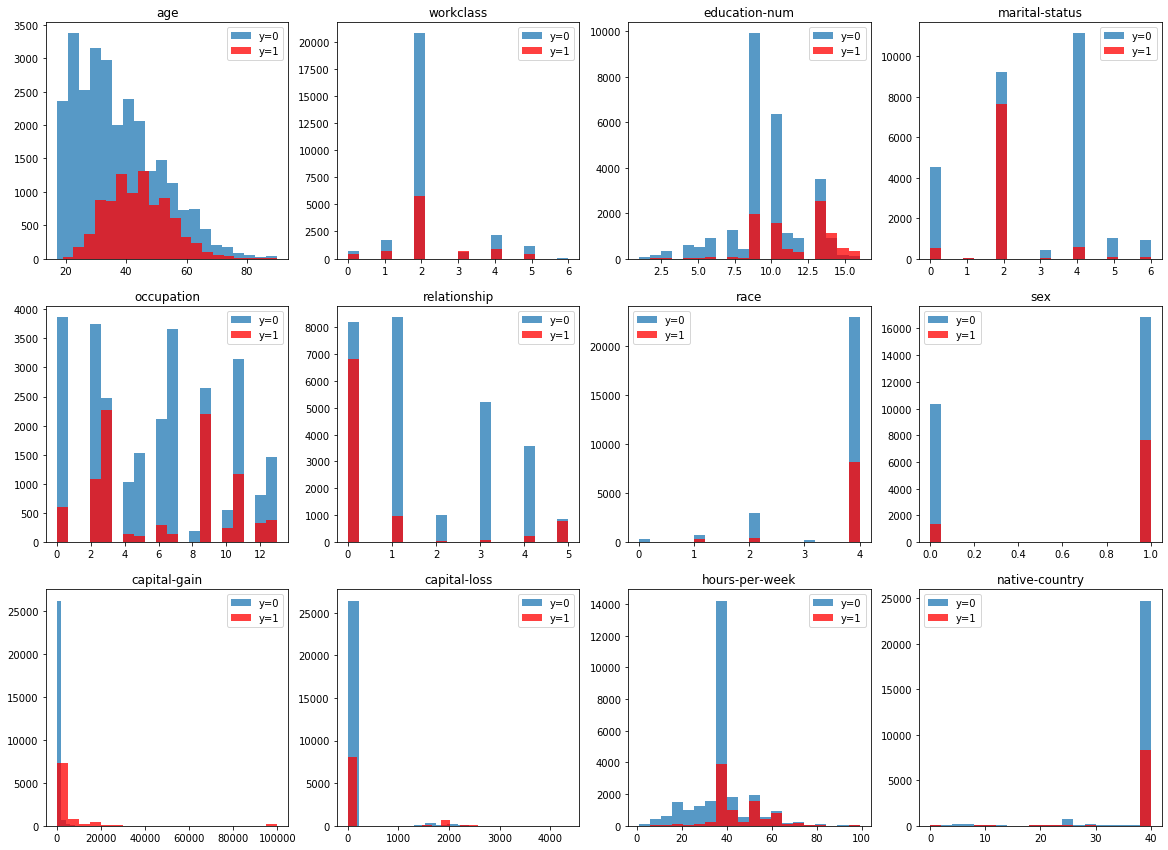

In [23]:
# Pintamos histogramas para cada clase
plt.figure(figsize=(20,20))

idx_0 =  data['income'] == 0
idx_1 =  data['income'] == 1

# your code here
for i,feature in enumerate(data.columns.drop(['income'])):
    plt.subplot(4,4,i+1)   
    plt.hist(data.ix[idx_0,feature],density=0, bins = 20, alpha=0.75,label='y=0')
    plt.hist(data.ix[idx_1,feature],density=0, bins= 20, facecolor='red', alpha=0.75,label='y=1')
    plt.legend()
    plt.title(feature)

plt.show()

### Correlación entre variables

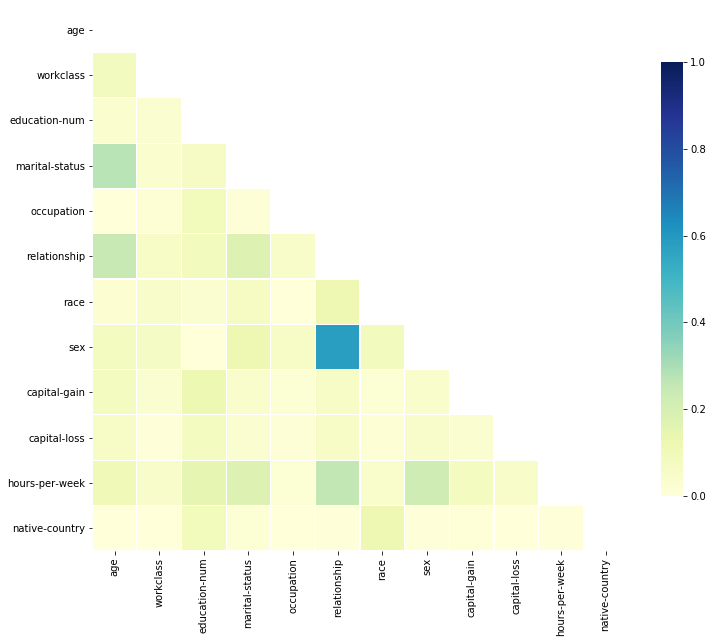

In [24]:
import seaborn as sns

# Compute the correlation matrix
corr = np.abs(data.drop(['income'], axis=1).corr())

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(12, 10))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask,vmin = 0.0, vmax=1.0, center=0.5,
            linewidths=.1, cmap="YlGnBu", cbar_kws={"shrink": .8})

plt.show()

~~Vemos una gran correlación entre Married-civ-spouse y husband. Tiene bastante lógica. De eliminar una eliminaría Married-civ-spouse que parece que tiene bastante correlación también con Never-married. Por ahora conservo todas. ~~
Veo algo de correlación entre relationship y sex, pero tampoco es muy alta, así que no hago nada con ninguna de las dos. 

In [25]:
#data = data.drop([' Married-civ-spouse'], axis = 1)

### División de variables.

In [26]:
# preparamos los datos
features = data.columns.drop(['income'])
X = data[features].values
y = data['income'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, stratify = y, random_state=0)

scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test  = scaler.transform(X_test)

print('Datos train: ', X_train.shape)
print('Datos test:  ', X_test.shape)

print('Propocion train:%0.3f'%np.mean(y_train))
print('Propocion test: %0.3f'%np.mean(y_test))

Datos train:  (27132, 12)
Datos test:   (9045, 12)
Propocion train:0.248
Propocion test: 0.248


### Selección de características.

Vamos a estudiar que variables son mas relevantes para la variable objetivo

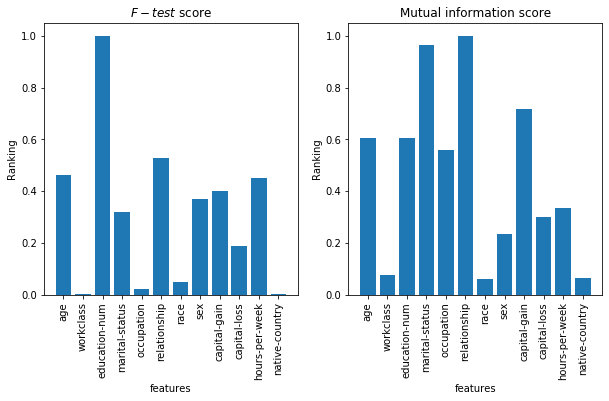

In [27]:
# do calculations
f_test, _ = f_classif(X_train, y_train)
f_test /= np.max(f_test)

mi = mutual_info_classif(X_train, y_train)
mi /= np.max(mi)

# do some plotting
plt.figure(figsize=(10, 5))

plt.subplot(1,2,1)
plt.bar(range(X.shape[1]),f_test,  align="center")
plt.xticks(range(X.shape[1]), features, rotation = 90)
plt.xlabel('features')
plt.ylabel('Ranking')
plt.title('$F-test$ score')


plt.subplot(1,2,2)
plt.bar(range(X.shape[1]),mi,  align="center")
plt.xticks(range(X.shape[1]), features, rotation = 90)
plt.xlabel('features')
plt.ylabel('Ranking')
plt.title('Mutual information score')

plt.show()

Vemos que hay algunas variables que no afectan mucho. Nos quedamos con las que tienen un valor superior a 0.5

In [28]:
features_sel = features[f_test>.05].tolist() + list(set(features[mi > .05].tolist()) - set(features[f_test > .05].tolist()))

print("Caracteristicas seleccionadas {}".format(features_sel))

X = data[features_sel].values
y = data['income'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, stratify = y, random_state=0)

scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test  = scaler.transform(X_test)

print('Datos train: ', X_train.shape)
print('Datos test:  ', X_test.shape)

print('Propocion train:%0.3f'%np.mean(y_train))
print('Propocion test: %0.3f'%np.mean(y_test))

Caracteristicas seleccionadas ['age', 'education-num', 'marital-status', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'occupation', 'workclass', 'race', 'native-country']
Datos train:  (27132, 12)
Datos test:   (9045, 12)
Propocion train:0.248
Propocion test: 0.248


### Búsqueda del modelo óptimo

Voy a probar distintos modelos de clasificación, empezando por los más sencillos y terminando con los más complejos. 

#### KNN

best mean cross-validation score: 0.836
best parameters: {'n_neighbors': 14}


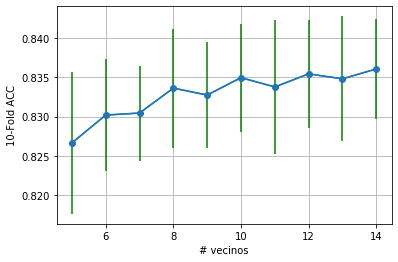

acc (train): 0.86
acc (test): 0.84


In [29]:
#vecinosIni = 1
#vecinosFin = 16

#vecinosIni = 10
#vecinosFin = 30

vecinosIni = 5
vecinosFin = 15
nVecinos = range(vecinosIni, vecinosFin, 1)

param_grid = {'n_neighbors':  np.arange(vecinosIni, vecinosFin, 1)}

grid = GridSearchCV(KNeighborsClassifier(), scoring= 'accuracy', param_grid=param_grid, cv = 10, n_jobs=8).fit(X_train, y_train)
print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))

scores = np.array(grid.cv_results_['mean_test_score']) 
stdvalues = np.array(grid.cv_results_['std_test_score'])
plt.plot(nVecinos,scores,'-o')
plt.errorbar(nVecinos, scores, yerr=stdvalues, ecolor='g')
plt.xlabel('# vecinos')
plt.ylabel('10-Fold ACC')
plt.grid()
plt.show()

print("acc (train): {:.2f}".format(grid.score(X_train, y_train)))
print("acc (test): {:.2f}".format(grid.score(X_test, y_test)))

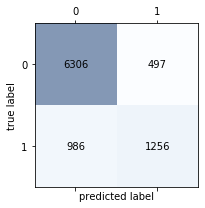

ACC:  0.8360420121614152
SEN:  0.56021409455843
ESP:  0.9269439952961929
PPV:  0.7164860239589276
FSC:  0.6287859824780976


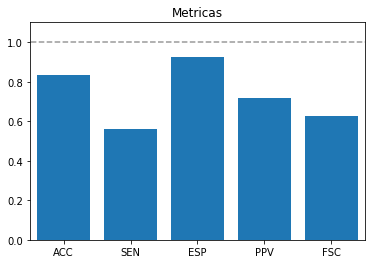

In [30]:
y_pred = grid.predict(X_test)

confmatKNN_test = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(confmatKNN_test)
calcula_metricas(confmatKNN_test)

Como podemos ver, pese a obtener un buen accuracy exactitud (0.85), el algoritmo no se comparta bien. La sensibilidad es algo baja. Probaremos ahora con regresión logistica


#### Regresión logistica

best mean cross-validation score: 0.767
best parameters: {'C': 26.366508987303554}


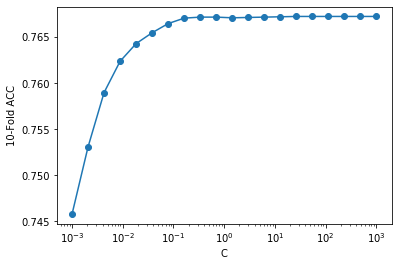

acc (train): 0.77
acc (test): 0.76


In [31]:
#vectorC = np.logspace(-10, 2, 20)
vectorC = np.logspace(-3, 3, 20)
param_grid = {'C': vectorC}

grid = GridSearchCV(LogisticRegression(class_weight = 'balanced', random_state = 0), scoring= 'accuracy', param_grid=param_grid, cv = 10, n_jobs=8)
grid.fit(X_train, y_train)

print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))

scores = np.array(grid.cv_results_['mean_test_score'])
plt.semilogx(vectorC,scores,'-o')
plt.xlabel('C')
plt.ylabel('10-Fold ACC')
plt.show()

print("acc (train): {:.2f}".format(grid.score(X_train, y_train)))
print("acc (test): {:.2f}".format(grid.score(X_test, y_test)))

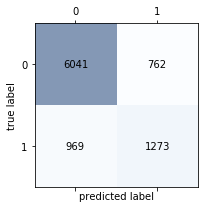

ACC:  0.8086235489220563
SEN:  0.5677966101694916
ESP:  0.8879905923857122
PPV:  0.6255528255528255
FSC:  0.5952770633621697


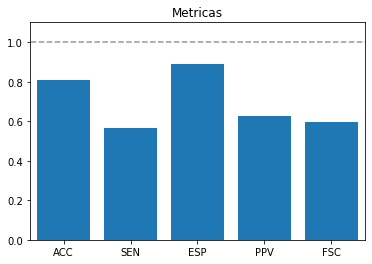

In [32]:
lr = LogisticRegression(fit_intercept=False, C =grid.best_params_['C']).fit(X_train, y_train)

y_pred = lr.predict(X_test)

confmatKNN_test = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(confmatKNN_test)
calcula_metricas(confmatKNN_test)

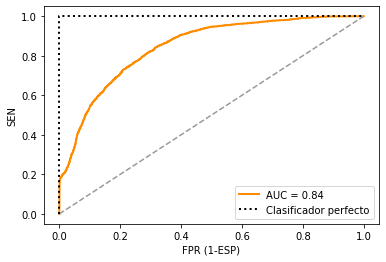

In [33]:
y_prob = lr.predict_proba(X_test)[:,1]

ejex, ejey, _ = roc_curve(y_test, y_prob)
roc_auc = auc(ejex, ejey)

plt.figure()
plt.plot(ejex, ejey, color='darkorange',lw=2, label='AUC = %0.2f' % roc_auc)

plt.plot([0, 1], [0, 1], color=(0.6, 0.6, 0.6), linestyle='--')
plt.plot([0, 0, 1],[0, 1, 1],lw=2, linestyle=':',color='black',label='Clasificador perfecto')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])

plt.xlabel('FPR (1-ESP)')
plt.ylabel('SEN')
plt.legend(loc="lower right")
plt.show()

Observamos peores resultados que con KNN. Mas verdaderos positivos, pero también mas falsos positivos y falsos negativos. Verdaderos negativos también tenemos menos.

#### Arbol de decisión

best mean cross-validation score: 0.802
best parameters: {'max_depth': 20.0}


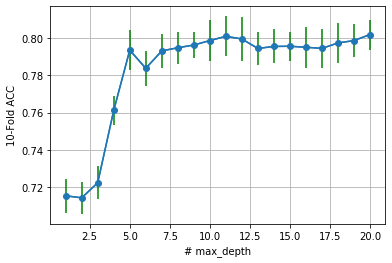

acc (train): 0.90
acc (test): 0.81


In [34]:
max_depth = np.linspace(1,20,20)
param_grid = {'max_depth': max_depth}

grid = GridSearchCV(DecisionTreeClassifier(class_weight = 'balanced', random_state = 0), 
                    scoring = 'accuracy', 
                    param_grid = param_grid, 
                    cv = 10, 
                    n_jobs=8)

grid.fit(X_train, y_train)
print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))

scores = np.array(grid.cv_results_['mean_test_score']) 
stdvalues = np.array(grid.cv_results_['std_test_score'])
plt.plot(max_depth,scores,'-o')
plt.errorbar(max_depth, scores, yerr=stdvalues, ecolor='g')
plt.xlabel('# max_depth')
plt.ylabel('10-Fold ACC')
plt.grid()
plt.show()

print("acc (train): {:.2f}".format(grid.score(X_train, y_train)))
print("acc (test): {:.2f}".format(grid.score(X_test, y_test)))

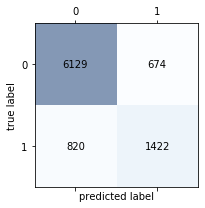

ACC:  0.8348258706467662
SEN:  0.6342551293487957
ESP:  0.9009260620314568
PPV:  0.6784351145038168
FSC:  0.6556016597510373


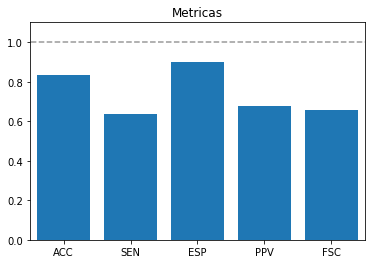

In [35]:
dt = DecisionTreeClassifier(max_depth = grid.best_params_['max_depth'], random_state = 0).fit(X_train, y_train)

y_pred = dt.predict(X_test)

confmatKNN_test = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(confmatKNN_test)
calcula_metricas(confmatKNN_test)

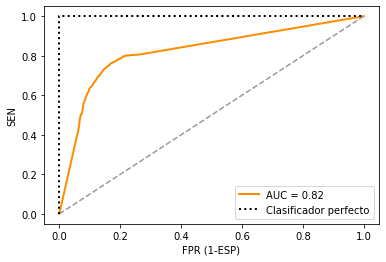

In [36]:
y_prob = dt.predict_proba(X_test)[:,1]

ejex, ejey, _ = roc_curve(y_test, y_prob)
roc_auc = auc(ejex, ejey)

plt.figure()
plt.plot(ejex, ejey, color='darkorange',lw=2, label='AUC = %0.2f' % roc_auc)

plt.plot([0, 1], [0, 1], color=(0.6, 0.6, 0.6), linestyle='--')
plt.plot([0, 0, 1],[0, 1, 1],lw=2, linestyle=':',color='black',label='Clasificador perfecto')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])

plt.xlabel('FPR (1-ESP)')
plt.ylabel('SEN')
plt.legend(loc="lower right")
plt.show()

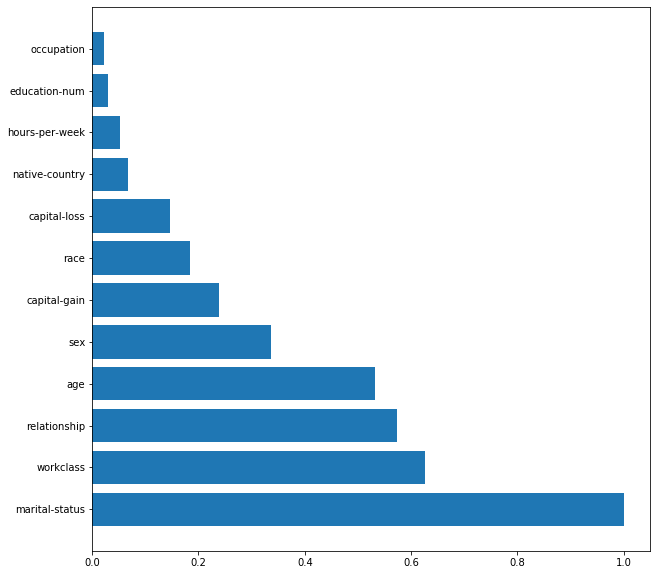

In [37]:
importances = dt.feature_importances_
importances = importances / np.max(importances)

indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10,10))
plt.barh(range(X_train.shape[1]),importances[indices])
plt.yticks(range(X_train.shape[1]),features[indices])
plt.show()

Obtenemos unos valores muy similares a KNN. 

#### RandomForestClassifier

/home/ivan/scr/Python/anaconda3/lib/python3.6/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/home/ivan/scr/Python/anaconda3/lib/python3.6/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


best mean cross-validation score: 0.845
best parameters: {'max_depth': 29}


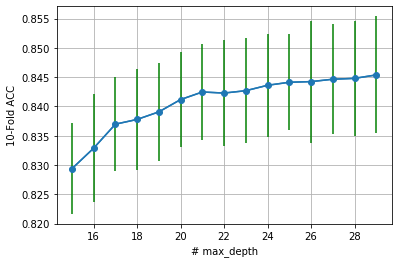

acc (train): 0.97
acc (test): 0.84


In [38]:
#max_depth = range(1,20)
max_depth = range(15,30)
tuned_parameters = {'max_depth': max_depth}

grid = GridSearchCV(RandomForestClassifier(class_weight = 'balanced',
                                           random_state=0, 
                                           n_estimators=200, 
                                           max_features='sqrt'), 
                                           param_grid=tuned_parameters,
                                           cv=10, 
                                           n_jobs=8) 
grid.fit(X_train, y_train)

print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))

scores = np.array(grid.cv_results_['mean_test_score']) 
stdvalues = np.array(grid.cv_results_['std_test_score'])
plt.plot(max_depth,scores,'-o')
plt.errorbar(max_depth, scores, yerr=stdvalues, ecolor='g')
plt.xlabel('# max_depth')
plt.ylabel('10-Fold ACC')
plt.grid()
plt.show()

print("acc (train): {:.2f}".format(grid.score(X_train, y_train)))
print("acc (test): {:.2f}".format(grid.score(X_test, y_test)))

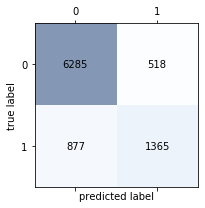

ACC:  0.845771144278607
SEN:  0.6088314005352364
ESP:  0.9238571218580038
PPV:  0.724907063197026
FSC:  0.6618181818181819


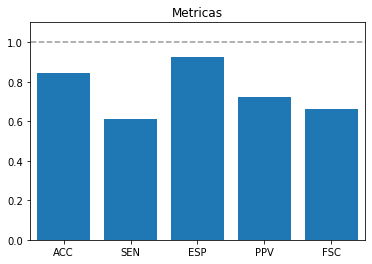

In [39]:
rf = RandomForestClassifier(max_depth = grid.best_params_['max_depth'], random_state = 0).fit(X_train, y_train)

y_pred = rf.predict(X_test)

confmatKNN_test = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(confmatKNN_test)
calcula_metricas(confmatKNN_test)

In [40]:
rf = RandomForestClassifier(max_depth = 10, random_state = 0).fit(X_train, y_train)

print("acc (train): {:.2f}".format(rf.score(X_train, y_train)))
print("acc (test): {:.2f}".format(rf.score(X_test, y_test)))

acc (train): 0.87
acc (test): 0.86


Con el max_depth de 24 obtenido en la validación cruzada obtenemos un modelo muy sobreentrenado. He hecho pruebas y con 10 tenemos un modelo más ajustado.

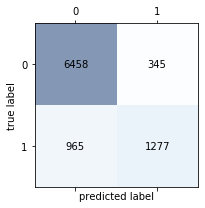

ACC:  0.8551686014372581
SEN:  0.5695807314897413
ESP:  0.9492870792297515
PPV:  0.7872996300863132
FSC:  0.6609730848861284


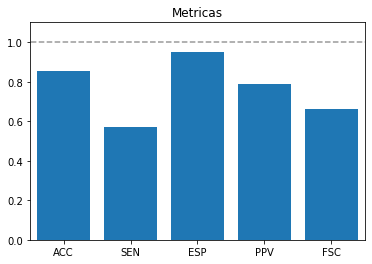

In [41]:
y_pred = rf.predict(X_test)

confmatKNN_test = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(confmatKNN_test)
calcula_metricas(confmatKNN_test)

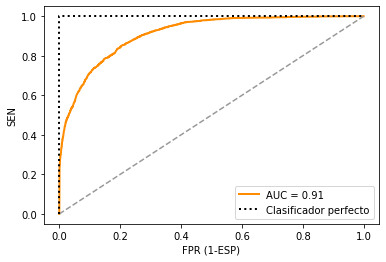

In [42]:
y_prob = rf.predict_proba(X_test)[:,1]

ejex, ejey, _ = roc_curve(y_test, y_prob)
roc_auc = auc(ejex, ejey)

plt.figure()
plt.plot(ejex, ejey, color='darkorange',lw=2, label='AUC = %0.2f' % roc_auc)

plt.plot([0, 1], [0, 1], color=(0.6, 0.6, 0.6), linestyle='--')
plt.plot([0, 0, 1],[0, 1, 1],lw=2, linestyle=':',color='black',label='Clasificador perfecto')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])

plt.xlabel('FPR (1-ESP)')
plt.ylabel('SEN')
plt.legend(loc="lower right")
plt.show()

/home/ivan/scr/Python/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  after removing the cwd from sys.path.
/home/ivan/scr/Python/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  """


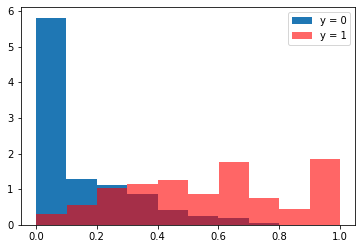

In [43]:
idx_0 = (y_test == 0)
idx_1 = (y_test == 1)

plt.hist(y_prob[idx_0], normed = 1, label = 'y = 0')
plt.hist(y_prob[idx_1], normed = 1, facecolor = 'r', alpha=0.6, label = 'y = 1')
plt.legend(loc = 1)
plt.show()

Según vamos avanzando y utilizando distintos modelo vamos obteniendo mejores resultados en general. Al final sacaré mis conclusiones 

#### GradientBoostingClassifier

In [44]:
#Niterations = [25,50,75,100]
Niterations = [50,100,150,175,200]
#Niterations = [225,250,275,300]
#Niterations = [325,350,375,400]
#Niterations = [25,200,275,350]

learningRate = [0.5,0.1,0.05,0.01]
#learningRate = [1, 0.5,0.1,0.05]


#param_grid = {'n_estimators': Niterations,'learning_rate':learningRate, 'max_depth': max_depth}
param_grid = {'n_estimators': Niterations,'learning_rate':learningRate}

grid = GridSearchCV(GradientBoostingClassifier(random_state=0, max_depth = 2), param_grid=param_grid, cv = 5, n_jobs=8)
grid.fit(X_train, y_train)

print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))
print("acc (train): {:.4f}".format(grid.score(X_train, y_train)))
print("acc (test): {:.4f}".format(grid.score(X_test, y_test)))

best mean cross-validation score: 0.868
best parameters: {'learning_rate': 0.5, 'n_estimators': 175}
acc (train): 0.8748
acc (test): 0.8695


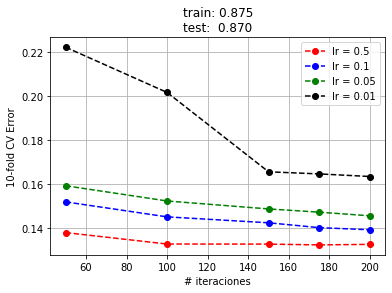

In [45]:
bt = GradientBoostingClassifier(random_state=0, max_depth=2, learning_rate = grid.best_params_['learning_rate'], n_estimators= grid.best_params_['n_estimators'] )
bt.fit(X_train,y_train)

error = 1-grid.cv_results_['mean_test_score'].reshape(len(learningRate),len(Niterations))
colors = ['r','b','g','k','m']
for i,lr in enumerate(learningRate):    
    plt.plot(Niterations,error[i,:],colors[i] + '--o',label='lr = %g'%lr)

plt.legend()
plt.xlabel('# iteraciones')
plt.ylabel('10-fold CV Error')
plt.title('train: %0.3f\ntest:  %0.3f'%(bt.score(X_train,y_train),bt.score(X_test,y_test)))
plt.grid()
plt.show()

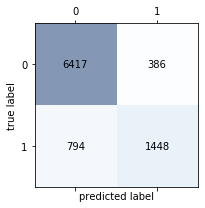

ACC:  0.8695411829740188
SEN:  0.6458519179304193
ESP:  0.9432603263266206
PPV:  0.7895310796074155
FSC:  0.7105004906771346


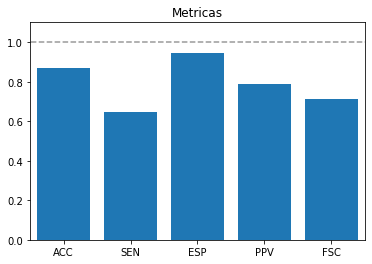

In [46]:

y_pred = bt.predict(X_test)

confmatKNN_test = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(confmatKNN_test)
calcula_metricas(confmatKNN_test)

Obtenemos como mejor learning_rate tenemos 0.5, pero en la gráfica 0.1 y 0.05 tienen buena pinta también. Voy a probar tambien son estos valores a ver que modelos obtengo

acc (train): 0.8662
acc (test): 0.8552


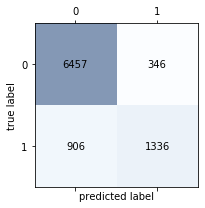

ACC:  0.8615809839690437
SEN:  0.5958965209634255
ESP:  0.9491400852565045
PPV:  0.7942925089179548
FSC:  0.6809378185524974


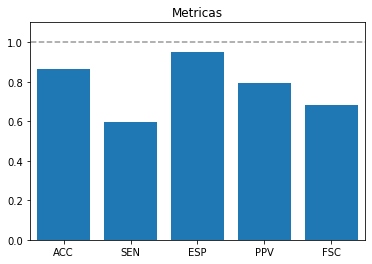

In [47]:
bt = GradientBoostingClassifier(random_state=0, 
                                max_depth=2, 
                                learning_rate = 0.1, 
                                n_estimators= grid.best_params_['n_estimators'] ).fit(X_train,y_train)


print("acc (train): {:.4f}".format(rf.score(X_train, y_train)))
print("acc (test): {:.4f}".format(rf.score(X_test, y_test)))

y_pred = bt.predict(X_test)

confmatKNN_test = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(confmatKNN_test)
calcula_metricas(confmatKNN_test)

acc (train): 0.8662
acc (test): 0.8552


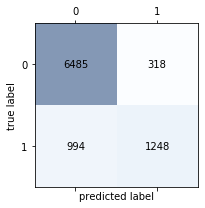

ACC:  0.854947484798231
SEN:  0.5566458519179304
ESP:  0.9532559165074233
PPV:  0.7969348659003831
FSC:  0.6554621848739496


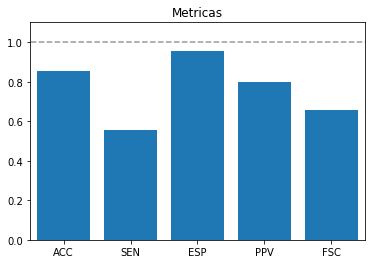

In [48]:
bt = GradientBoostingClassifier(random_state=0, 
                                max_depth=2, 
                                learning_rate = 0.05, 
                                n_estimators= grid.best_params_['n_estimators'] ).fit(X_train,y_train)


print("acc (train): {:.4f}".format(rf.score(X_train, y_train)))
print("acc (test): {:.4f}".format(rf.score(X_test, y_test)))

y_pred = bt.predict(X_test)

confmatKNN_test = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(confmatKNN_test)
calcula_metricas(confmatKNN_test)

Al final hay valores similares. Aunque mejores unos, empeoran otros. 

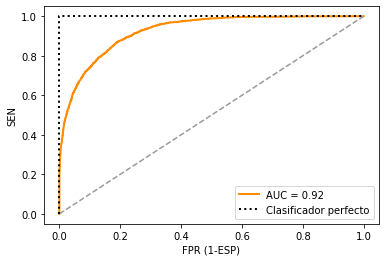

In [49]:
bt = GradientBoostingClassifier(random_state=0, max_depth=2, learning_rate = grid.best_params_['learning_rate'], n_estimators= grid.best_params_['n_estimators'] )
bt.fit(X_train,y_train)


y_prob = bt.predict_proba(X_test)[:,1]

ejex, ejey, _ = roc_curve(y_test, y_prob)
roc_auc = auc(ejex, ejey)

plt.figure()
plt.plot(ejex, ejey, color='darkorange',lw=2, label='AUC = %0.2f' % roc_auc)

plt.plot([0, 1], [0, 1], color=(0.6, 0.6, 0.6), linestyle='--')
plt.plot([0, 0, 1],[0, 1, 1],lw=2, linestyle=':',color='black',label='Clasificador perfecto')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])

plt.xlabel('FPR (1-ESP)')
plt.ylabel('SEN')
plt.legend(loc="lower right")
plt.show()

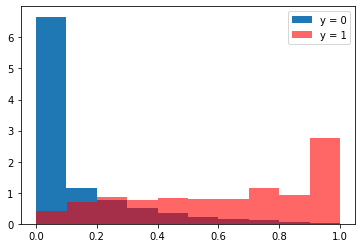

In [50]:
idx_0 = (y_test == 0)
idx_1 = (y_test == 1)

plt.hist(y_prob[idx_0], density = 1, label = 'y = 0')
plt.hist(y_prob[idx_1], density = 1, facecolor = 'r', alpha=0.6, label = 'y = 1')
plt.legend(loc = 1)
plt.show()

Con GradientBoostingClassifier obtenemos el mejor modelo predictorio. Así que es con el modelo que nos quedamos.

### Aplicación del modelo

In [65]:
data = pd.read_csv('./data/census_test.csv')
data.head(10)

# elimino education_level
data = data.drop(['education_level'],axis=1)

le = LabelEncoder()

cols_bin = ['race', 'sex', 'native-country', 'workclass', 'marital-status', 'occupation', 'relationship']

for col in cols_bin:
    data[col] = le.fit_transform(data[col])
        
    
data.head(10)

,id,age,workclass,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,0,28,2,9.0,4,5,3,2,0,0.0,0.0,40.0,37
1,1,35,2,9.0,5,9,2,2,0,0.0,0.0,40.0,37
2,2,33,2,9.0,2,2,0,4,1,0.0,0.0,30.0,37
3,3,18,2,9.0,4,11,1,4,1,0.0,0.0,30.0,37
4,4,53,2,11.0,2,3,0,4,1,0.0,0.0,40.0,37
5,5,37,2,14.0,2,3,0,4,1,0.0,1977.0,40.0,37
6,6,41,4,9.0,2,3,0,4,1,0.0,0.0,50.0,37
7,7,41,2,10.0,2,2,0,2,1,0.0,0.0,40.0,37
8,8,76,2,15.0,2,9,0,4,1,9386.0,0.0,25.0,37
9,9,38,0,10.0,4,0,1,4,0,0.0,1980.0,40.0,37


In [66]:
features = data.columns.drop(['id'])

X = data[features].values
Xs = scaler.transform(X)

y_pred_ = bt.predict(Xs)
data['target'] = y_pred_
data_save = data[['id', 'target']]
data_save.head(10)

,id,target
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0
5,5,0
6,6,0
7,7,0
8,8,0
9,9,0


In [67]:
np.unique(data_save['target'], return_counts=True)

(array([0, 1]), array([9044,    1]))

In [68]:
data_save.to_csv('./data/census_results.csv')